In [1]:
import pandas as pd
import numpy as np
import math
np.random.seed(0)

from operator import attrgetter
import xgboost as xgb

from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import eli5
from eli5.sklearn import PermutationImportance

from tqdm import tqdm
from sklearn.preprocessing import minmax_scale
import holidays

from scipy import stats
from scipy.stats import norm, boxcox

import scikitplot as skplt
from sklearn import metrics
import catboost as ctb
import matplotlib.pyplot as plt
import gc

In [2]:
pd.set_option('display.max_columns',4500)
pd.set_option('display.max_rows',2000)
pd.set_option('display.width',11000)

In [3]:
train = pd.read_feather('train_data.ftr')
# test = pd.read_feather('test_data.ftr')
# train_raw = pd.concat([train, test], axis=0)

train_raw = train.copy()
del train#, test
gc.collect()

0

In [7]:
def get_feats(df, black_list = ["target",'id','diff', 'cohort_month', 'customer_ID', 'customer_ID_cat']):
    feats_obj = df.select_dtypes(['object'])

    for col in feats_obj:
        df[col+'_cat'] = df[col].factorize()[0]

    feats = df.select_dtypes(['number', 'bool'])
    
    return [x for x in feats if x not in black_list]

def make_experiment(model, feats=None, threshold=0.5, n_splits=3, black_list=["target",'id','diff', 'cohort_month']):

    
    feats = get_feats(train_raw)

    df_train = train_raw[ train_raw["target"].notnull() ]
    X_train = df_train[feats].values
    y_train = df_train["target"].values

    X_train.fillna(-1, inplace=True)

    scores = []
    cv=StratifiedKFold(n_splits=n_splits, shuffle=True)#shuffle=True, random_state=0
    for train_idx, test_idx in cv.split(X_train, y_train):    

        model.fit(X_train[train_idx], y_train[train_idx])

        y_probas = model.predict_proba(X_train[test_idx])
        y_pred = (y_probas[:,1] > threshold).astype(np.int)
        #y_pred = model.predict(X_train[test_idx])

        print(classification_report(y_train[test_idx], y_pred))
        skplt.metrics.plot_confusion_matrix(y_train[test_idx], y_pred, normalize=True)
        skplt.metrics.plot_precision_recall(y_train[test_idx], y_probas)

        score = accuracy_score(y_train[test_idx], y_pred)
        scores.append(score)
    
    print("Score: ", np.mean(scores), np.std(scores))
    
    skplt.estimators.plot_learning_curve(model, X_train, y_train, cv=cv, scoring="f1", random_state=0)

    print('Done.')

def im(model_cls, model_params, verbose=True):
    #df_new = feature_engineering(df)
    feats = get_feats(train_raw)
    
    if verbose:
        print('feats: {}'.format(feats))
        print('params: {}'.format(model_params))
        
    df_train = train_raw[ train_raw["target"].notnull()].sample(frac=1)

    X, y = df_train[feats], df_train['target']

    X.fillna(-1, inplace=True)
    model = model_cls(**model_params)
    model.fit(X, y)
    
    return eli5.show_weights(model, feature_names=feats, top=150)

def save_result(filename, model, threshold=0.1):

    df_train = train_raw[ train_raw["target"].notnull() ]
    df_test = train_raw[ train_raw["target"].isnull() ].copy()

    #df_train
    #df_test.fillna()

    #num_feats = train_raw.select_dtypes(["number",'bool']).columns
    feats = get_feats(train_raw)
    #feats = [x for x in num_feats if x not in ["target"]]
    
    model.fit(df_train[feats].values, df_train["target"].values)

    df_test["target"] =  model.predict_proba(df_test[feats].values)[:,1]
    #(model.predict_proba(df_test[feats].values)[:,1] > threshold).astype(np.float)
    output_file = "{}".format(filename)
    df_test.rename(columns={'target':'prediction'}, inplace=True)
    df_test[ ["customer_ID", "prediction"] ].to_csv(output_file, index=False)
    print("Saved: ", output_file)
    print("Feats:", len(feats))

In [8]:
train_raw['S_2'] = pd.to_datetime(train_raw['S_2'], format = '%d/%m/%Y')
train_raw.set_index('S_2', inplace=True)
train_raw.sort_index(inplace=True)

In [9]:
tmp = train_raw.isna().sum().mul(100).div(len(train_raw)).sort_values(ascending=False)
missingDF = pd.DataFrame(tmp).reset_index()
drop_cols = missingDF[missingDF[0]>70]["index"].values
train_raw.drop(columns = drop_cols,axis=1, inplace=True)
len(drop_cols)

25

In [10]:
train_raw["S_2_month"] = train_raw.index.month.astype('int')
train_raw["S_2_year"] = train_raw.index.year
train_raw["S_2_date"] = train_raw.index.date
train_raw["day"] = train_raw.index.day.astype('int')
#train_raw["day_of_year"] = train_raw.index.dayofyear
train_raw['cohort'] = train_raw.groupby('customer_ID')['S_2_date'].transform('min')
train_raw['diff'] = train_raw['S_2_date']-train_raw['cohort']
train_raw['days_diff'] = train_raw['diff'].apply(attrgetter('days')).astype('int')
train_raw['S_2_weekday'] = train_raw.index.weekday.astype('int')
#train_raw['S_2_quarter'] = train_raw.index.quarter
#train_raw['weekend'] = train_raw['S_2_weekday'].map(lambda x: 1 if x in [5,6] else 0)
train_raw['month_12'] = train_raw.S_2_month.map(lambda x: x if x == 12 else 0).astype('int')
train_raw.drop(columns=['diff'], inplace=True)

#train_raw = pd.get_dummies(data=train_raw, columns=['S_2_weekday'], prefix='cohort_cat')

train_raw['days_diff_373'] = train_raw.days_diff.map(lambda x: 1 if x == 373 else 0)
train_raw['days_diff_384'] = train_raw.days_diff.map(lambda x: 1 if x == 384 else 0)
train_raw['days_diff_0'] = train_raw.days_diff.map(lambda x: 1 if x == 0 else 0)

train_raw['B_30_my'] = train_raw.B_30.astype('object')
train_raw['B_30_my'].fillna(3, inplace=True)
train_raw['B_30_my'] = train_raw['B_30_my'].astype('int')

train_raw['B_38_my'] = train_raw.B_38.astype('object')
train_raw['B_38_my'].fillna(3, inplace=True)
train_raw['B_38_my'] = train_raw['B_38_my'].astype('int')
train_raw
train_raw['D_114_my'] = train_raw.D_114.astype('object')
train_raw['D_114_my'].fillna(-1, inplace=True)
train_raw['D_114_my'] = train_raw['D_114_my'].astype('int')

train_raw['D_116_my'] = train_raw.D_116.astype('object')
train_raw['D_116_my'].fillna(-1, inplace=True)
train_raw['D_116_my'] = train_raw['D_116_my'].astype('int')

train_raw['D_117_my'] = train_raw.D_117.astype('object')
train_raw['D_117_my'].fillna(7, inplace=True)
train_raw['D_117_my'] = train_raw['D_117_my'].astype('int')

train_raw['D_120_my'] = train_raw.D_120.astype('object')
train_raw['D_120_my'].fillna(1, inplace=True)
train_raw['D_120_my'] = train_raw['D_120_my'].astype('int')

train_raw['D_126_my'] = train_raw.D_126.astype('object')
train_raw['D_126_my'].fillna(-1, inplace=True)
train_raw['D_126_my'] = train_raw['D_126_my'].astype('int')

#
# train_raw['B_30_my'] = train_raw.B_30.astype('object')
# train_raw['B_30_my'].fillna(0, inplace=True)
# train_raw['B_30_my'] = train_raw['B_30_my'].astype('int')

# train_raw['B_38_my'] = train_raw.B_38.astype('object')
# train_raw['B_38_my'].fillna(2, inplace=True)
# train_raw['B_38_my'] = year_train_raw['B_38_my'].astype('int')

# train_raw['D_114_my'] = train_raw.D_114.astype('object')
# train_raw['D_114_my'].fillna(1, inplace=True)
# train_raw['D_114_my'] = train_raw['D_114_my'].astype('int')

# train_raw['D_116_my'] = train_raw.D_116.astype('object')
# train_raw['D_116_my'].fillna(0, inplace=True)
# train_raw['D_116_my'] = train_raw['D_116_my'].astype('int')

# train_raw['D_117_my'] = train_raw.D_117.astype('object')
# train_raw['D_117_my'].fillna(-1, inplace=True)
# train_raw['D_117_my'] = train_raw['D_117_my'].astype('int')

# train_raw['D_120_my'] = train_medians = traw.D_120.astype('object')
# train_raw['D_120_my'].fillna(0, inplace=True)
# train_raw['D_120_my'] = train_raw['D_120_my'].astype('int')

# train_raw['D_126_my'] = train_raw.D_126.astype('object')
# train_raw['D_126_my'].fillna(-1, inplace=True)
# train_raw['D_126_my'] = train_raw['D_126_my'].astype('int')

dict_customers = train_raw.groupby('customer_ID')['customer_ID'].count().to_dict()
train_raw['count_S_2'] = train_raw.customer_ID.map(dict_customers)

train_raw['rok_ms'] = train_raw.S_2_year*100 + train_raw.S_2_month


In [129]:
dict_month = {
    1: 201703,
    2: 201704,
    3: 201705,
    4: 201706,
    5: 201707,
    6: 201708,
    7: 201709,
    8: 201710,
    9: 201711,
    10: 201712,
    11: 201801,
    12: 201802,
    13: 201803    
}

In [ ]:
medians = train_raw.groupby( ['S_2_year', 'S_2_month']).agg([np.median, np.mean, np.min, np.max])['P_2'].reset_index()
medians.rename(columns={'median': 'median_y_m_p_2','mean': 'mean_y_m_p_2','min': 'min_y_m_p_2','max': 'max_y_m_p_2'}, inplace=True)
train_raw = pd.merge(train_raw, medians, on=['S_2_year','S_2_month'], how = 'left')

del medians
gc.collect()

0

In [13]:
def stat_param(vals):
    param = {
        'count': vals.count(),
        'mean': vals.mean(),
        'std': vals.std(),
        'V': vals.std()/vals.mean()*100,
        'min': vals.min(),
        'max': vals.max(),
        'pencertil_25': np.percentile(vals,25),
        'median': vals.median(),
        'pencertil_75': np.percentile(vals,75),
        'percertil_1': np.percentile(vals,1),
        'percertil_99': np.percentile(vals,99),
        'percentile_99_1': np.percentile(vals,99)/np.percentile(vals,1),
        'q': np.subtract(*np.percentile(vals, [75, 25])),
        'V_q': (np.subtract(*np.percentile(vals, [75,25])))/vals.median()*100,
        'nulls': vals.isnull().sum()/vals.shape[0]

    }
    return param

def get_my_min_max(vals, coef=1.5):
    q1 = np.percentile(vals, 25)
    q3 = np.percentile(vals, 75)
    iqr = q3 - q1

    my_min = q1 - coef*iqr
    my_max = q3 + coef*iqr
    
    print("outliers (min): ", vals[ vals < my_min ].shape[0])
    print("outliers (max): ", vals[ vals > my_max ].shape[0])

    return my_min, my_max

In [18]:
float_list = ['D_109']
for col in float_list:
    train_raw[col] = train_raw[col].astype('float64')

In [54]:
my = train_raw[['D_109','customer_ID']].reset_index()
my['rok'] = my.S_2.dt.year
my['ms'] = my.S_2.dt.month
my['rok_ms'] = my.rok*100 + my.ms

In [25]:
revenue = train_raw['D_109']
offset=1
revenue_log = np.log(revenue+offset)
revenue_log2 = np.log2(revenue+offset)
revenue_log10 = np.log10(revenue+offset)
revenue_sqrt = np.sqrt(revenue)
revenue_boxcox, maxlog = boxcox(revenue+offset)
revenue_boxcox = pd.Series(revenue_boxcox)


df_revenue = pd.DataFrame()
df_revenue['revenue_log'] = revenue_log
df_revenue['revenue_log2'] = revenue_log2
df_revenue['revenue_log10'] = revenue_log10
df_revenue['revenue_sqrt'] = revenue_sqrt
df_revenue['revenue_boxcox'] = revenue_boxcox

In [27]:
for col in df_revenue.columns.to_list():
    print(col)
    print(stat_param(df_revenue[col]))

revenue_log
{'count': 5531451, 'mean': 0.006129756400577968, 'std': 0.028254679190286992, 'V': 460.9429371063244, 'min': 0.0, 'max': 0.6980181107945418, 'pencertil_25': 0.0025012180992860377, 'median': 0.004996195712164128, 'pencertil_75': 0.007483070773629206, 'percertil_1': 9.956460237731948e-05, 'percertil_99': 0.009869350238311748, 'percentile_99_1': 99.12509067138058, 'q': 0.004981852674343168, 'V_q': 99.71292081721221, 'nulls': 0.0}
revenue_log2
{'count': 5531451, 'mean': 0.008843369160971223, 'std': 0.04076288554973567, 'V': 460.94293710632445, 'min': 0.0, 'max': 1.0070272668939686, 'pencertil_25': 0.0036084949480216857, 'median': 0.007207986777249891, 'pencertil_75': 0.010795789095735996, 'percertil_1': 0.0001436413580978403, 'percertil_99': 0.014238462645608668, 'percentile_99_1': 99.12509067138059, 'q': 0.00718729414771431, 'V_q': 99.71292081721221, 'nulls': 0.0}
revenue_log10
{'count': 5531451, 'mean': 0.0026621193801821515, 'std': 0.012270851260288294, 'V': 460.942937106324

/home/magdalena/Dokumenty/Skrypty/mypython/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


{'count': 0, 'mean': nan, 'std': nan, 'V': nan, 'min': nan, 'max': nan, 'pencertil_25': nan, 'median': nan, 'pencertil_75': nan, 'percertil_1': nan, 'percertil_99': nan, 'percentile_99_1': nan, 'q': nan, 'V_q': nan, 'nulls': 1.0}


/home/magdalena/Dokumenty/Skrypty/mypython/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [9]:
float_list = ['B_6', 'B_10', 'D_69', 'P_2', 'B_2', 'D_48', 'D_39', 'S_3', 'D_50','B_5', 'D_50', 'S_5', 'B_12', 'B_13', 'D_61', 'D_65', 'S_12', 'B_21', 'R_7', 'B_26', 'S_16', 'R_14', 'S_23', 'B_40']
for col in float_list:
    train_raw[col] = train_raw[col].astype('float32')

In [17]:
# import seaborn as sns

/home/magdalena/Dokumenty/Skrypty/mypython/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/magdalena/Dokumenty/Skrypty/mypython/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/magdalena/Dokumenty/Skrypty/mypython/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel densit

<AxesSubplot:xlabel='D_69', ylabel='Density'>

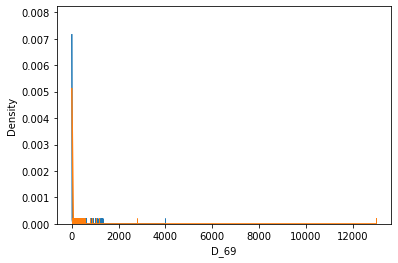

In [22]:
# sns.distplot(train_raw[train_raw['target']==1]['D_69'], hist=False, rug=True)
# sns.distplot(train_raw[train_raw['target']==0]['D_69'], hist=False, rug=True)

In [68]:
# il = train_raw[(train_raw['D_69'] > 500) & (train_raw['target']==1)]['D_69'].index.to_list()

In [70]:
# train_raw.iloc[341347]['D_69'] = mean_69_1

/home/magdalena/Dokumenty/Skrypty/mypython/lib/python3.9/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [4]:
# mean_69_0 = train_raw[train_raw['target']==0]['D_69'].mean()
# mean_69_1 = train_raw[train_raw['target']==1]['D_69'].mean()
# train_raw['D_69_my'] = train_raw.apply(lambda x: mean_69_0 if (x['D_69'] > 500) and (x['target']==0)  else x, axis=1)
# #train_raw['D_69_my'] = train_raw.apply(lambda x: mean_69_1 if (x['D_69_my'] > 500) and (x['target']==1)  else x, axis=1)

In [10]:
# for feat in tqdm(float_list):
#     if train_raw[feattrain_raw].skew() < 0.25: continue
#     train_raw['feat + _boxcox'], maxlog = boxcox(train_raw[feat]+1000)
#     #train_raw['feat + _boxcox'] = D_48_boxcox
# #sqrt_cont_feats = [feat for feat in train_raw.columns if feat.startswith('cont') and 'sqrt' in feat]
# boxcox_cont_feats = [feat for feat in train_raw.columns if feat.startswith('cont') and '_boxcox' in feat]

In [10]:
#all_cont_feats = ['B_6', 'B_10', 'D_69', 'P_2', 'B_2', 'D_48', 'D_39', 'S_3', 'D_50']

for feat in tqdm(float_list):
    if train_raw[feat].skew() < 0.25: continue
    train_raw[feat + '_sqrt'] = np.sqrt( minmax_scale(train_raw[feat]) )
    train_raw[feat + '_log1p'] = np.log1p( minmax_scale(train_raw[feat]) )
    #train_raw[feat + '_log2'] = np.log2( minmax_scale(train_raw[feat]+60) )
    #train_raw[feat + '_log10'] = np.log10( minmax_scale(train_raw[feat]+60) )
    # train_raw['feat + _boxcox'], maxlog = boxcox(D_48)
    #train_raw['feat + _boxcox'] = D_48_boxcox
#sqrt_cont_feats = [feat for feat in train_raw.columns if feat.startswith('cont') and 'sqrt' in feat]
log_cont_feats = [feat for feat in train_raw.columns if feat.startswith('cont') and 'log' in feat]

100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


In [13]:
# #all_cont_feats = ['B_6', 'B_10', 'D_69', 'P_2', 'B_2', 'D_48', 'D_39', 'S_3', 'D_50']

# for feat in tqdm(float_list):
#     if train_raw[feat].skew() < 0.25: continue
#     #train_raw[feat + '_sqrt'] = np.sqrt( minmax_scale(train_raw[feat]) )
#     #train_raw[feat + '_log1p'] = np.log1p( minmax_scale(train_raw[feat]) )
#     #train_raw[feat + '_log2'] = np.log2( minmax_scale(train_raw[feat]+60) )
#     train_raw[feat + '_log10'] = np.log10( minmax_scale(train_raw[feat]+1000) )
#     # train_raw['feat + _boxcox'], maxlog = boxcox(D_48)
#     #train_raw['feat + _boxcox'] = D_48_boxcox
# #sqrt_cont_feats = [feat for feat in train_raw.columns if feat.startswith('cont') and 'sqrt' in feat]
# log_cont_feats = [feat for feat in train_raw.columns if feat.startswith('cont') and 'log' in feat]

In [14]:
train_raw.shape

(16895213, 225)

In [15]:
# train_raw['wakacje'] = train_raw.S_2_month.map(lambda x: 1 if (x == 7) | (x == 8) else 0).astype('int')
    
# train_raw['week_in_month'] = pd.to_numeric(train_raw.index.day/7)
# train_raw['week_in_month'] = train_raw['week_in_month'].apply(lambda x: math.ceil(x))

In [11]:
train_raw['D_63_mul'] = train_raw['D_63'].map(lambda x: x if x.startswith('C',1) else 'X')
train_raw['D_64_mul'] = train_raw['D_64'].map(lambda x: 'R' if x=='' else x)
train_raw['D_63_agg'] = train_raw['D_63'].map(lambda x: 1 if str(x).startswith('C',1) else 0).astype('int')

categorical_columns = ["D_63","D_64",'D_63_mul']

for col in categorical_columns:
    train_raw[col+'_cat'] = train_raw[col].factorize()[0]

In [17]:
#train_raw = pd.get_dummies(data=train_raw, columns=['D_64_mul'], prefix='D_64_mul')

In [18]:
#train_raw = pd.get_dummies(data=train_raw, columns=['D_63_mul'], prefix='D_63_mul')

In [19]:
# # train_raw['D_63_mul'] = train_raw['D_63'].map(lambda x: x if x.startswith('C',1) else 'X')
# # train_raw['D_64_mul'] = train_raw['D_64'].map(lambda x: 'R' if x=='' else x)
# # train_raw['D_63_agg'] = train_raw['D_63'].map(lambda x: 1 if str(x).startswith('C',1) else 0).astype('int')

# # train_raw = pd.get_dummies(data=train_raw, columns=['D_64_mul'], prefix='D_64_mul')
# # train_raw = pd.get_dummies(data=train_raw, columns=['D_63_mul'], prefix='D_63_mul')

# categorical_columns = ["D_63","D_64",'D_63_mul']

# for col in categorical_columns:
#     train_raw[col+'_cat'] = train_raw[col].factorize()[0]



In [20]:
# train_raw[train_raw['target'] == 1 ]["D_64"].value_counts().plot(kind="bar");

In [21]:
#train_raw = pd.get_dummies(data=train_raw, columns=['S_2_weekday'], prefix='weekday_')

In [22]:
#train_raw = pd.get_dummies(data=train_raw, columns=['S_2_month'], prefix='S_2_month')
#train_raw = pd.get_dummies(data=train_raw, columns=['days_diff'], prefix='days_diff')

In [23]:
# first_day = train_raw.index.values[0]
# train_raw['days_of_first_day'] = train_raw.index.map(lambda x: (x - first_day).days)

In [24]:
# holiday_dict = holidays.CountryHoliday('US', years=[2017,2018])
# train_raw['holiday'] = train_raw.index.map(holiday_dict)
# train_raw = pd.get_dummies(data=train_raw, columns=['holiday'], prefix='hdays')

In [25]:
#train_raw.select_dtypes('category')

In [13]:
# data_min_max = train_raw[['customer_ID','S_2_date']].groupby(['customer_ID']).agg( S_2_min=("S_2_date", np.min), S_2_max=("S_2_date", np.max)).reset_index()
# min_max = data_min_max.merge(train_raw[['P_2','customer_ID','S_2_date']], how='left',left_on=['customer_ID', 'S_2_min'], right_on=['customer_ID','S_2_date'], 
# suffixes=('', '_min')).merge(train_raw[['P_2','customer_ID','S_2_date']], how='left',left_on=['customer_ID', 'S_2_max'], right_on=['customer_ID','S_2_date'], 
# suffixes=('', '_max'))

# del data_min_max
# gc.collect()

# min_max['P_2_%'] = min_max.apply(lambda x: (x['P_2_max']-x['P_2'])/x['P_2'] if x['P_2'] != np.NaN else 1, axis=1)
# min_max = min_max[['customer_ID','P_2_%']]


In [12]:
train_raw = train_raw.groupby(['customer_ID']).nth(-1).reset_index()

# train_raw = train_raw.merge(min_max, how='left', on='customer_ID')

# del min_max
# gc.collect()

In [14]:
train_raw.isnull().sum().sum()

10696507

In [27]:
# train_raw_first = train_raw.groupby(['customer_ID']).nth(1).reset_index()

In [13]:
im(ctb.CatBoostClassifier, dict(n_estimators=240, depth=5, random_state=0, verbose=False))

feats: ['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'D_68', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'P_4', 'D_74', 'D_75', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14', 'R_15', 'D_84', 'R_16', 'S_18', 'D_86', 'R_17', 'R_18', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_105', 'D_107', 'B_36', 'B_37', 'R_27

/home/magdalena/Dokumenty/Skrypty/mypython/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Weight,Feature
0.1858,P_2
0.0839,B_2
0.0457,D_44
0.0371,D_39_sqrt
0.0368,S_3_sqrt
0.0300,B_1
0.0298,B_4
0.0294,R_1
0.0271,D_43
0.0259,B_8


In [ ]:
im(ctb.CatBoostClassifier, dict(n_estimators=240, depth=5, random_state=0, verbose=False))

feats: ['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'D_68', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'P_4', 'D_74', 'D_75', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14', 'R_15', 'D_84', 'R_16', 'S_18', 'D_86', 'R_17', 'R_18', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_105', 'D_107', 'B_36', 'B_37', 'R_27

/home/magdalena/Dokumenty/Skrypty/mypython/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Weight,Feature
0.1556,P_2
0.1124,B_18
0.0700,B_8
0.0423,B_1
0.0339,S_3
0.0327,D_48
0.0322,D_39_log1p
0.0315,R_1
0.0240,D_50_log1p
0.0178,B_5


In [33]:
im(ctb.CatBoostClassifier, dict(n_estimators=240, depth=5, random_state=0, verbose=False))

feats: ['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'D_68', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'P_4', 'D_74', 'D_75', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14', 'R_15', 'D_84', 'R_16', 'S_18', 'D_86', 'R_17', 'R_18', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_105', 'D_107', 'B_36', 'B_37', 'R_27

/home/magdalena/Dokumenty/Skrypty/mypython/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Weight,Feature
0.1416,P_2
0.1227,B_18
0.0442,S_3
0.0404,D_39
0.0399,D_45
0.0357,B_9
0.0331,D_50_sqrt
0.0281,D_51
0.0280,D_44
0.0273,D_48


In [27]:
im(ctb.CatBoostClassifier, dict(n_estimators=240, depth=5, random_state=0, verbose=False))

feats: ['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'D_68', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'P_4', 'D_74', 'D_75', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14', 'R_15', 'D_84', 'R_16', 'S_18', 'D_86', 'R_17', 'R_18', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_105', 'D_107', 'B_36', 'B_37', 'R_27

/home/magdalena/Dokumenty/Skrypty/mypython/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Weight,Feature
0.1631,P_2
0.0920,B_2
0.0408,D_39
0.0396,B_9
0.0338,D_51
0.0337,S_3_log1p
0.0336,D_45
0.0317,D_48
0.0303,R_1
0.0303,D_43


/tmp/ipykernel_102162/2162565872.py:178: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = (y_probas[:,1] > threshold).astype(np.int)


              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93    113362
         1.0       0.84      0.73      0.78     39609

    accuracy                           0.90    152971
   macro avg       0.88      0.84      0.86    152971
weighted avg       0.89      0.90      0.89    152971



/tmp/ipykernel_102162/2162565872.py:178: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = (y_probas[:,1] > threshold).astype(np.int)


              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93    113362
         1.0       0.84      0.73      0.78     39609

    accuracy                           0.89    152971
   macro avg       0.88      0.84      0.86    152971
weighted avg       0.89      0.89      0.89    152971



/tmp/ipykernel_102162/2162565872.py:178: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = (y_probas[:,1] > threshold).astype(np.int)


              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93    113361
         1.0       0.84      0.74      0.79     39610

    accuracy                           0.90    152971
   macro avg       0.88      0.84      0.86    152971
weighted avg       0.89      0.90      0.89    152971

Score:  0.8953766835979805 0.0008546869997254113
Done.


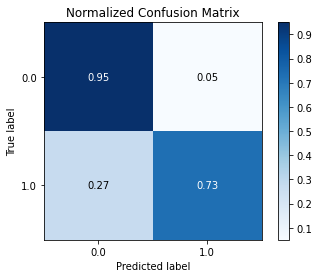

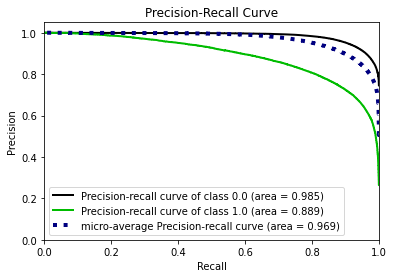

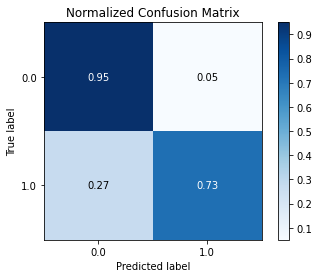

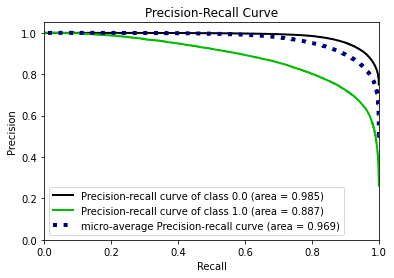

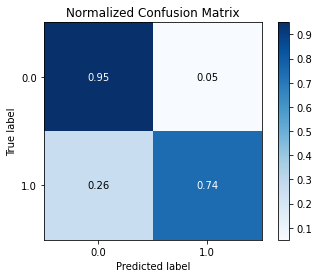

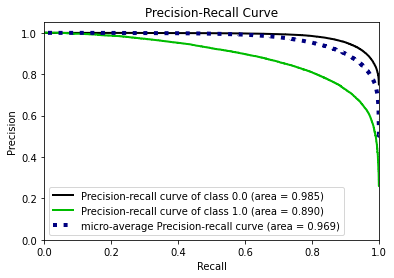

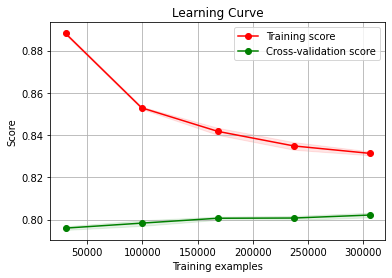

In [29]:
model = ctb.CatBoostClassifier(n_estimators=240, depth=5, random_state=0, verbose=False)
make_experiment(model, threshold=0.6)

In [16]:
model = ctb.CatBoostClassifier(n_estimators=240, depth=5, random_state=0, verbose=False)
save_result("lgb_threshold_0.7%_sqr_all_feats.csv", model, threshold=0.6)

Saved:  lgb_threshold_0.7%_sqr_all_feats.csv
Feats: 221
